# SMS text classification - Spam or Good?


---
Dataset from Assignment : **"Spam Classification"** 

### Importation of essential libraries
---
> NumPy : Library for Numeric Computations in Python  
> Pandas : Library for Data Acquisition and Preparation  
> Matplotlib : Low-level library for Data Visualization  
> Seaborn : Higher-level library for Data Visualization <br>
> Re : Used for substitution of common words and finding words later <br>
> NLTK : Used to process natural language in texts <br>
> Graphviz : Visualisation of Decision tree <br>
> Plotly : Data Visualisation <br>
> Stopwords : removal of common words with similar meaning such as me, my, myself <br>
> TweetTokenizer : split words in strings into lists <br> 
> LabelEncoder : changes label strings into numbers for easier handling of data <br>
> SnowballStemmer : Changes words into root form <br>
> WordCloud : Data Visualisation of most common words <br>
> MultinomialNB : Naive Bayes Algorithm for classification <br>


In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()
import re
import nltk
import graphviz
from sklearn.tree import export_graphviz
import plotly.express as px
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


[nltk_data] Downloading package stopwords to /Users/cv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


---
**Approach** <br>

1. Explore and identify distinguishable features<br>
2. Cleaning of dataset (removal of duplicated data, stemming, tokenising, ... etc)<br>
3. Binary Tree classification<br>
4. Random forest classification<br>
5. Naive Bayes<br>
6. Compare and contrast, selection of better model<br>
---

### Import Dataset

In [2]:
smsData = pd.read_table('sms.txt', sep = "\t", header = None)
smsData.columns = ["LABEL", "TEXT"]
smsData.head()

LABEL                                               TEXT
0  good  Go until jurong point, crazy.. Available only ...
1  good                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3  good  U dun say so early hor... U c already then say...
4  good  Nah I don't think he goes to usf, he lives aro...

#### Description of the dataset

> **LABEL** : Spam or Good (not spam) <br>
> **TEXT** : Texts 

In [3]:
print("Dimension of data:\n",smsData.shape)
print("Data types:\n",smsData.dtypes)

Dimension of data:
 (5572, 2)
Data types:
 LABEL    object
TEXT     object
dtype: object


---
## Explore Dataset

> **Number of spam and good texts :**

good    4825
spam     747
Name: LABEL, dtype: int64


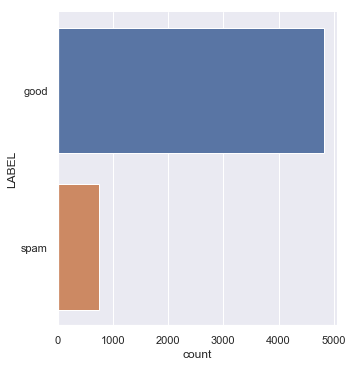

In [4]:
# analysing data
print(smsData['LABEL'].value_counts())

sb.catplot(y = "LABEL", data = smsData, kind = "count", height = 5)

> **Duplicated data**

In [5]:
print("There are", len(smsData["TEXT"].unique()), "unique text messages." )
print("Hence there are", len(smsData["TEXT"])-len(smsData["TEXT"].unique()), "duplicated data.\n")

# Identify duplicated texts
dupid_data = smsData[smsData.duplicated("TEXT", keep = False)]

print("Examples of duplicated data:\n",dupid_data.head(n= 10))

dupids = dupid_data["TEXT"].unique()

There are 5158 unique text messages.
Hence there are 414 duplicated data.

Examples of duplicated data:
    LABEL                                               TEXT
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...
7   good  As per your request 'Melle Melle (Oru Minnamin...
8   spam  WINNER!! As a valued network customer you have...
9   spam  Had your mobile 11 months or more? U R entitle...
11  spam  SIX chances to win CASH! From 100 to 20,000 po...
12  spam  URGENT! You have won a 1 week FREE membership ...
45  good                   No calls..messages..missed calls
56  spam  Congrats! 1 year special cinema pass for 2 is ...
62  good                          Its a part of checking IQ
65  spam  As a valued customer, I am pleased to advise y...


> **Remove duplicates**

In [6]:
# ref to https://www.geeksforgeeks.org/python-pandas-dataframe-drop_duplicates/
smsData.drop_duplicates(subset="TEXT", keep='last', inplace=True)

> **Reset index after removing duplicates**

In [7]:
smsData= smsData.reset_index()
smsData=smsData.drop(columns='index')

smsData_nodup= smsData.copy()

> **Separate into spam and good :**

In [8]:
spam_data = smsData[smsData["LABEL"] == 'spam']
good_data = smsData[smsData["LABEL"] == 'good']

#### Identify distinguishable features :
(1) Length of text<br>
(2) Number of Punctuations in a single text<br>
(3) Presence of URLS<br>
(4) Presence of HTMLS<br>

> **Difference in length of spam and good**

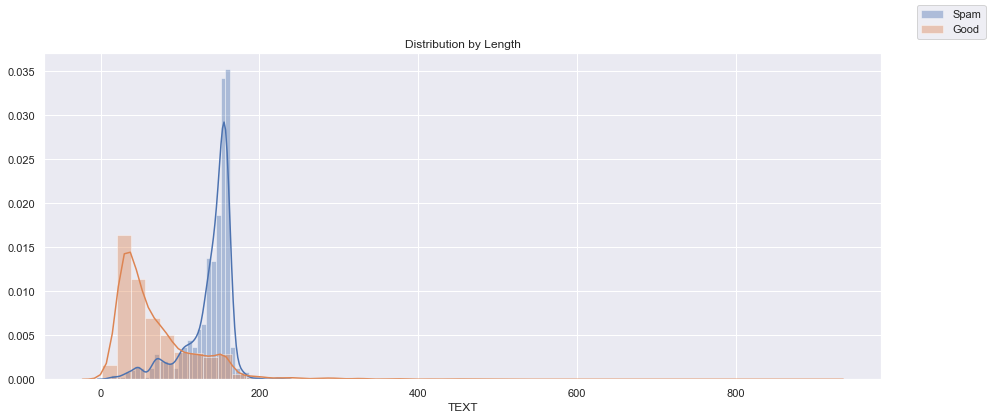

In [9]:
# ref to https://www.edureka.co/community/46313/python-pandas-find-length-of-string-in-dataframe
fig = plt.figure(figsize=(15,6))

spam = spam_data['TEXT'].str.len()
sb.distplot(spam)

good = good_data['TEXT'].str.len()
sb.distplot(good)

plt.title('Distribution by Length')
fig.legend(labels=['Spam','Good'])
plt.show()

In [10]:
# ref to https://www.kaggle.com/gauthampughazh/disaster-or-not-plotly-use-tfidf-h2o-ai-automl

PUNCTUATION_PATTERN = re.compile(r'[^a-zA-Z \d]') 
URL_PATTERN = re.compile(r"(https:\/\/\S+)|(http:\/\/\S+)|(www\.\S+)")
HTML_TAGS_PATTERN = re.compile(r'<.*>')
NUMBERS = re.compile(r'\d')
DATETIME = re.compile(r'\d.*(week)(.+)|\d.*(day)(.+)|\d.*(month)(.+)|\d.*(hour)(.+)|\d.*(year)(.+)|\d.*(hr)(.+)|\d.*(min)(.+)|\d.*(feb)(ruary)?|\d.*apr(il)?|\d.*june?|\d.*(sept(ember)?)|\d.*(jan)(uary)?|\d.*ma(r(ch)?|y)|\d.*ju(ly?)|\d.*aug(ust)?|\d.*oct(ober)?|\d.*(nov)(ember)?|\d.*(dec)(ember)?')

def get_punctuations(text): # identify punctuations
    
    return PUNCTUATION_PATTERN.findall(text) 

def has_html_tags(text): # identify HTMLs
    
    return 'Texts with HTML tags' if re.search(HTML_TAGS_PATTERN, text) else 'Texts without HTML tags'

def has_urls(text): # identify URLs
    
    return 'Texts with URLs' if re.search(URL_PATTERN, text) else 'Texts without URLs'

def has_numbers(text): # identify URLs
    
    return 'Have numbers' if re.search(NUMBERS, text) else 'No number'

def has_date(text): # identify dates
    return 'Have date' if re.search(DATETIME,text) else 'No date'

> **Punctuations count in Spam**

In [11]:
spam_punc = spam_data.apply(lambda x: get_punctuations(x['TEXT']), axis=1)
spam_punc = spam_punc[spam_punc.notnull()].explode().value_counts()

fig = px.bar(x=spam_punc.index, y=spam_punc.values)
fig.update_layout(title_text='Punctuation count of spam text', xaxis_title='Punctuations', yaxis_title='Count')


> **vs. Punctuations count in Good**

In [12]:
good_punc = good_data.apply(lambda x: get_punctuations(x['TEXT']), axis=1)
good_punc = good_punc[good_punc.notnull()].explode().value_counts()

fig = px.bar(x=good_punc.index, y=good_punc.values)
fig.update_layout(title_text='Punctuation count of good text', xaxis_title='Punctuations', yaxis_title='Count')

> **Texts containing HTMLs**

In [13]:
has_tags = smsData.apply(lambda x: has_html_tags(x['TEXT']), axis=1).to_frame() # series -> dataframe
has_tags.columns = ['HTML tags'] 
has_tags['LABEL'] = smsData['LABEL']

px.histogram(has_tags, x='HTML tags', color='LABEL', barmode='group')


In [14]:
hasdate = smsData.apply(lambda x: has_date(x['TEXT']), axis=1).to_frame()
hasdate.columns = ['DATE'] 
hasdate['LABEL'] = smsData['LABEL']

px.histogram(hasdate, x='DATE', color='LABEL', barmode='group')

> **Texts containing URLs**

In [15]:
has_urls = smsData.apply(lambda x: has_urls(x['TEXT']), axis=1).to_frame() # series -> dataframe
has_urls.columns = ['URLs'] 
has_urls['LABEL'] = smsData['LABEL']

px.histogram(has_urls, x='URLs', color='LABEL', barmode='group')

> **Texts containing Numbers**

In [16]:
hasno = smsData.apply(lambda x: has_numbers(x['TEXT']), axis=1).to_frame() # series -> dataframe
hasno.columns = ['NUMBERS'] 
hasno['LABEL'] = smsData['LABEL']

px.histogram(hasno, x='NUMBERS', color='LABEL', barmode='group')

*Notes* <br>
> Good data has over abundance of punctuations compared to that of spam data, could be the result of more good data(around 85%) compared to spam(around 15%) of total data?<br>
> HTMLs are all in spam data and none in good data<br>
> Both spam and good data contains urls , though the majority is present in spam<br>
> Majority of spam contain numbers while only small portion of good contain numbers
---

#### Counting number of punctuations in each text to store in new dataframe

In [17]:
smsData['TEXT PROTOTYPE'] = smsData["TEXT"]
smsData["TEXT PROTOTYPE"] = smsData["TEXT PROTOTYPE"].apply(lambda x: re.sub(r'[^a-zA-Z \d]',r'^', x)) # subst all punct w ^

punc_list=[]
def PUNCT(data):
    for row in data:
        count=0
        for word in row:
            if word == '^':
                count+=1
        punc_list.append(count)
    return punc_list

In [18]:
Punctuation_count = pd.DataFrame(PUNCT(smsData['TEXT PROTOTYPE']))
Punctuation_count.columns = ["PUNCTUATION COUNT"]

#### Counting number of digits in each text to store in new dataframe

In [19]:
smsData['DIGIT'] = smsData["TEXT"]
smsData["DIGIT"] = smsData["DIGIT"].apply(lambda x: re.sub(r'\d',r'1', x)) # subst all digits with 1

digit_list=[]
def Digit(data):
    for row in data:
        count=0
        for word in row:
            if word == '1':
                count+=1
        digit_list.append(count)
    return digit_list

In [20]:
digit_count = pd.DataFrame(Digit(smsData['DIGIT']))
digit_count.columns = ["DIGIT COUNT"]

# Cleaning dataset
---
1) Lower alphabets<br>
2) Replacing of common words <br>
e.g <br>
txt-> text<br>
get-> got<br>
3) Removal of punctuations <br>
4) Tokenization of texts<br>
5) Removal of stopwords<br>
6) Encode **spam == 1**, *good == 2*<br>
7) Stemming<br>

---

> **Lower alphabets**

In [21]:
# Convert all texts to lowercase
smsData["TEXT"] = smsData["TEXT"].str.lower()

> **Replacing of common words**

In [22]:
# converting txt -> text
# ref to https://docs.python.org/3/library/re.html
smsData["TEXT"] = smsData["TEXT"].apply(lambda x: re.sub(r'(.)(txt)',r' text ', x))
smsData["TEXT"] = smsData["TEXT"].apply(lambda x: re.sub(r'(.)(get)',r' got ', x))

> **Removal of punctuations**<br>
> **Tokenization of texts**<br>
> **Removal of stopwords**

In [23]:
# remove punctuations
# ref to https://docs.python.org/3/library/re.html
def remove_punct(text):
    new_words = []
    for word in text:
        w = re.sub(r'[(.,?:\‘)!]','',word) #remove punctuations in bracket
        new_words.append(w)
    return new_words

# tokenization
# ref to https://stackoverflow.com/questions/34714162/preventing-splitting-at-apostrophies-when-tokenizing-words-using-nltk
tt = TweetTokenizer()

def tokenization_w(words):
    w_new = []
    for w in (words[:]):  # for NumPy = words[:]
        nltk_tokens = tt.tokenize(w)
        if nltk_tokens != '' or nltk_tokens == '\'':
            w_new.append(nltk_tokens)
    return w_new

# remove stopwords like me, my, myself
# ref to https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe
stop_words = stopwords.words('english')

In [24]:
smsData['TEXT']=remove_punct(smsData['TEXT'])
smsData['TEXT']=tokenization_w(smsData['TEXT'])
smsData['TEXT']=smsData['TEXT'].apply(lambda x: [item for item in x if item not in stop_words])

> **Encode labels**

In [25]:
# Converting string labels into numbers.
# ref to https://www.datacamp.com/community/tutorials/categorical-data
lb_make = LabelEncoder()
smsData['LABEL'] = lb_make.fit_transform(smsData['LABEL']) # 0 -> good 1 -> spam


> **Stem**

In [26]:
# changing words into root forms
# ref to https://stackoverflow.com/questions/37443138/python-stemming-with-pandas-dataframe
snowball = SnowballStemmer(language = 'english', ignore_stopwords=True)
smsData['TEXT'] = smsData['TEXT'].apply(lambda x: [snowball.stem(y) for y in x]) # Stem every word.
smsData # Print dataframe.

LABEL                                               TEXT  \
0         0  [go, jurong, point, crazi, avail, bugi, n, gre...   
1         0                       [ok, lar, joke, wif, u, oni]   
2         0      [u, dun, say, earli, hor, u, c, alreadi, say]   
3         0       [nah, think, goe, usf, live, around, though]   
4         1  [freemsg, hey, darl, 3, week, word, back, i'd,...   
...     ...                                                ...   
5153      1  [2nd, time, tri, 2, contact, u, u, £, 750, pou...   
5154      0                     [ü, b, go, esplanad, fr, home]   
5155      0                    [piti, *, mood, soani, suggest]   
5156      0  [guy, bitch, act, like, i'd, interest, buy, so...   
5157      0                                 [rofl, true, name]   

                                         TEXT PROTOTYPE  \
0     Go until jurong point^ crazy^^ Available only ...   
1                         Ok lar^^^ Joking wif u oni^^^   
2     U dun say so early hor^^^ U c already then say^^^   
3     Nah I don^t think he goes to usf^ he lives aro...   
4     FreeMsg Hey there darling it^s been 3 week^s n...   
...                                                 ...   
5153  This is the 2nd time we have tried 2 contact u...   
5154               Will ^ b going to esplanade fr home^   
5155  Pity^ ^ was in mood for that^ So^^^any other s...   
5156  The guy did some bitching but I acted like i^d...   
5157                         Rofl^ Its true to its name   

                                                  DIGIT  
0     Go until jurong point, crazy.. Available only ...  
1                         Ok lar... Joking wif u oni...  
2     U dun say so early hor... U c already then say...  
3     Nah I don't think he goes to usf, he lives aro...  
4     FreeMsg Hey there darling it's been 1 week's n...  
...                                                 ...  
5153  This is the 1nd time we have tried 1 contact u...  
5154               Will ü b going to esplanade fr home?  
5155  Pity, * was in mood for that. So...any other s...  
5156  The guy did some bitching but I acted like i'd...  
5157                         Rofl. Its true to its name  

[5158 rows x 4 columns]

## Creating and storing distinguishable features in dataset
---

In [27]:
has_urls=has_urls.reset_index()
has_tags=has_tags.reset_index()
hasdate=hasdate.reset_index()

#### Features to put into dataframe: 

1) Presence of HTMLs<br>
2) Presence of URLs<br>
3) Presence of datetime<br>
4) Length of texts<br>
5) Punctuation count<br>
6) Digit count

In [28]:
has_tags.drop(columns=['LABEL']) # leftover from previous

has_tags["HTML tags"]=has_tags["HTML tags"].replace("Texts with HTML tags", "1")
has_tags["HTML tags"]=has_tags["HTML tags"].replace("Texts without HTML tags", "0")

has_urls.drop(columns=['LABEL'])

has_urls["URLs"]=has_urls["URLs"].replace("Texts with URLs", "1")
has_urls["URLs"]=has_urls["URLs"].replace("Texts without URLs", "0")

hasdate.drop(columns=['LABEL'])

hasdate["DATE"]=hasdate["DATE"].replace("Have date", "1")
hasdate["DATE"]=hasdate["DATE"].replace("No date", "0")

length=smsData[smsData['LABEL'] != 'bad']['TEXT'].str.len().to_frame(name="LENGTH")
length = length.reset_index()

/Users/cv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [29]:
smsData_ref = pd.concat([smsData['LABEL'], smsData[smsData['LABEL'] != 'bad']['TEXT'].str.len()], axis=1)

smsData_ref=smsData_ref.reset_index()

In [30]:
smsData_ref=smsData_ref.drop(columns='index')

In [31]:
# put below features into dataframe (smsData_ref)

smsData_ref['LENGTH'] = length["LENGTH"]
smsData_ref['PUNCT COUNT'] = Punctuation_count["PUNCTUATION COUNT"]
smsData_ref['URLs'] = has_urls["URLs"]
smsData_ref['HTMLs'] = has_tags["HTML tags"]
smsData_ref['DIGIT COUNT']=digit_count["DIGIT COUNT"]
smsData_ref['DATETIME'] = hasdate["DATE"]


smsData_ref= smsData_ref.drop(columns= 'TEXT')

# Identifying frequency of certain words
---

Repeated separation into spam and good, this time with encoding.

In [32]:
spam_data = smsData[smsData["LABEL"] == 1]
good_data = smsData[smsData["LABEL"] == 0]

Identify unique words and store into list

In [33]:
# identifying unique words 
def freq(data_list):
    unique_freq_list=[]
    for row in data_list:
        for word in row:
            if word.isdigit() == False and word not in unique_freq_list and word.isalnum() == True: # only alphabetic strings
                unique_freq_list.append(word)
    return unique_freq_list

spam_unique_list=freq(spam_data['TEXT'])
good_unique_list=freq(spam_data['TEXT'])

Store all words appearing in text into another list

In [34]:
# getting all the words and return them as a list

spamlist=[]
for x in spam_data['TEXT']:
    spamlist.extend(x)
    

goodlist=[]
for x in good_data['TEXT']:
    goodlist.extend(x)

Compare and count the occurence of unique words in the entire text dataframe<br>
Only storing them if count is above 10<br>
Else 0 is stored so as not to affect total elements in dataframe

In [35]:
# counting how many times unique words occured in the entire spam/good texts
def freq_table(unique_list,total_list):
    count_list=[]
    for word in unique_list:
        word_freq=total_list.count(word)
        if word_freq<10:
            count_list.append(0);
        else:
            count_list.append(word_freq)
    return count_list

spamcount_list=freq_table(spam_unique_list,spamlist)

Generate a dataframe of the occurence of each unique words <br>
and sort by descending order

#### Data Visualisation of words

> **Spam**

In [36]:
# put into a dataframe for analyses later
spamfreq = pd.DataFrame({'WORDS' : spam_unique_list, 'FREQUENCY' : spamcount_list}) 

# sort values by descending order and get top 30
spamfreq=spamfreq.sort_values(by=['FREQUENCY'],ascending=False)
spamfreq= spamfreq.head(n=30)

spamfreq.head()

WORDS  FREQUENCY
59  call        331
23  text        309
61  free        187
87     u        128
36    ur        119

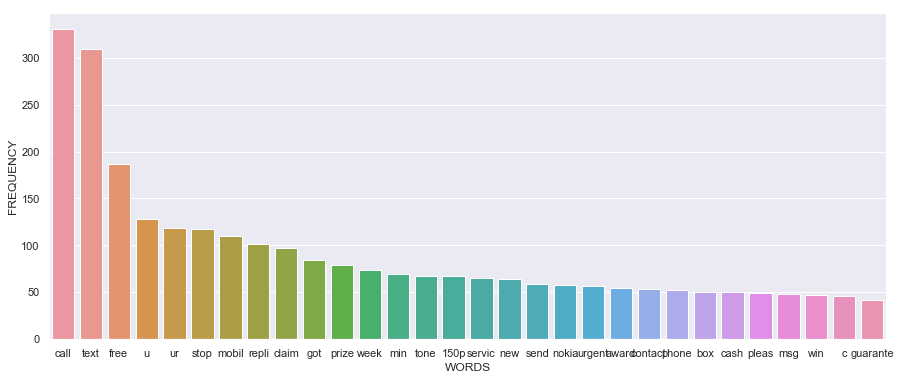

In [37]:
fig = plt.figure(figsize=(15,6))
sb.barplot(x="WORDS", y="FREQUENCY",data=spamfreq)

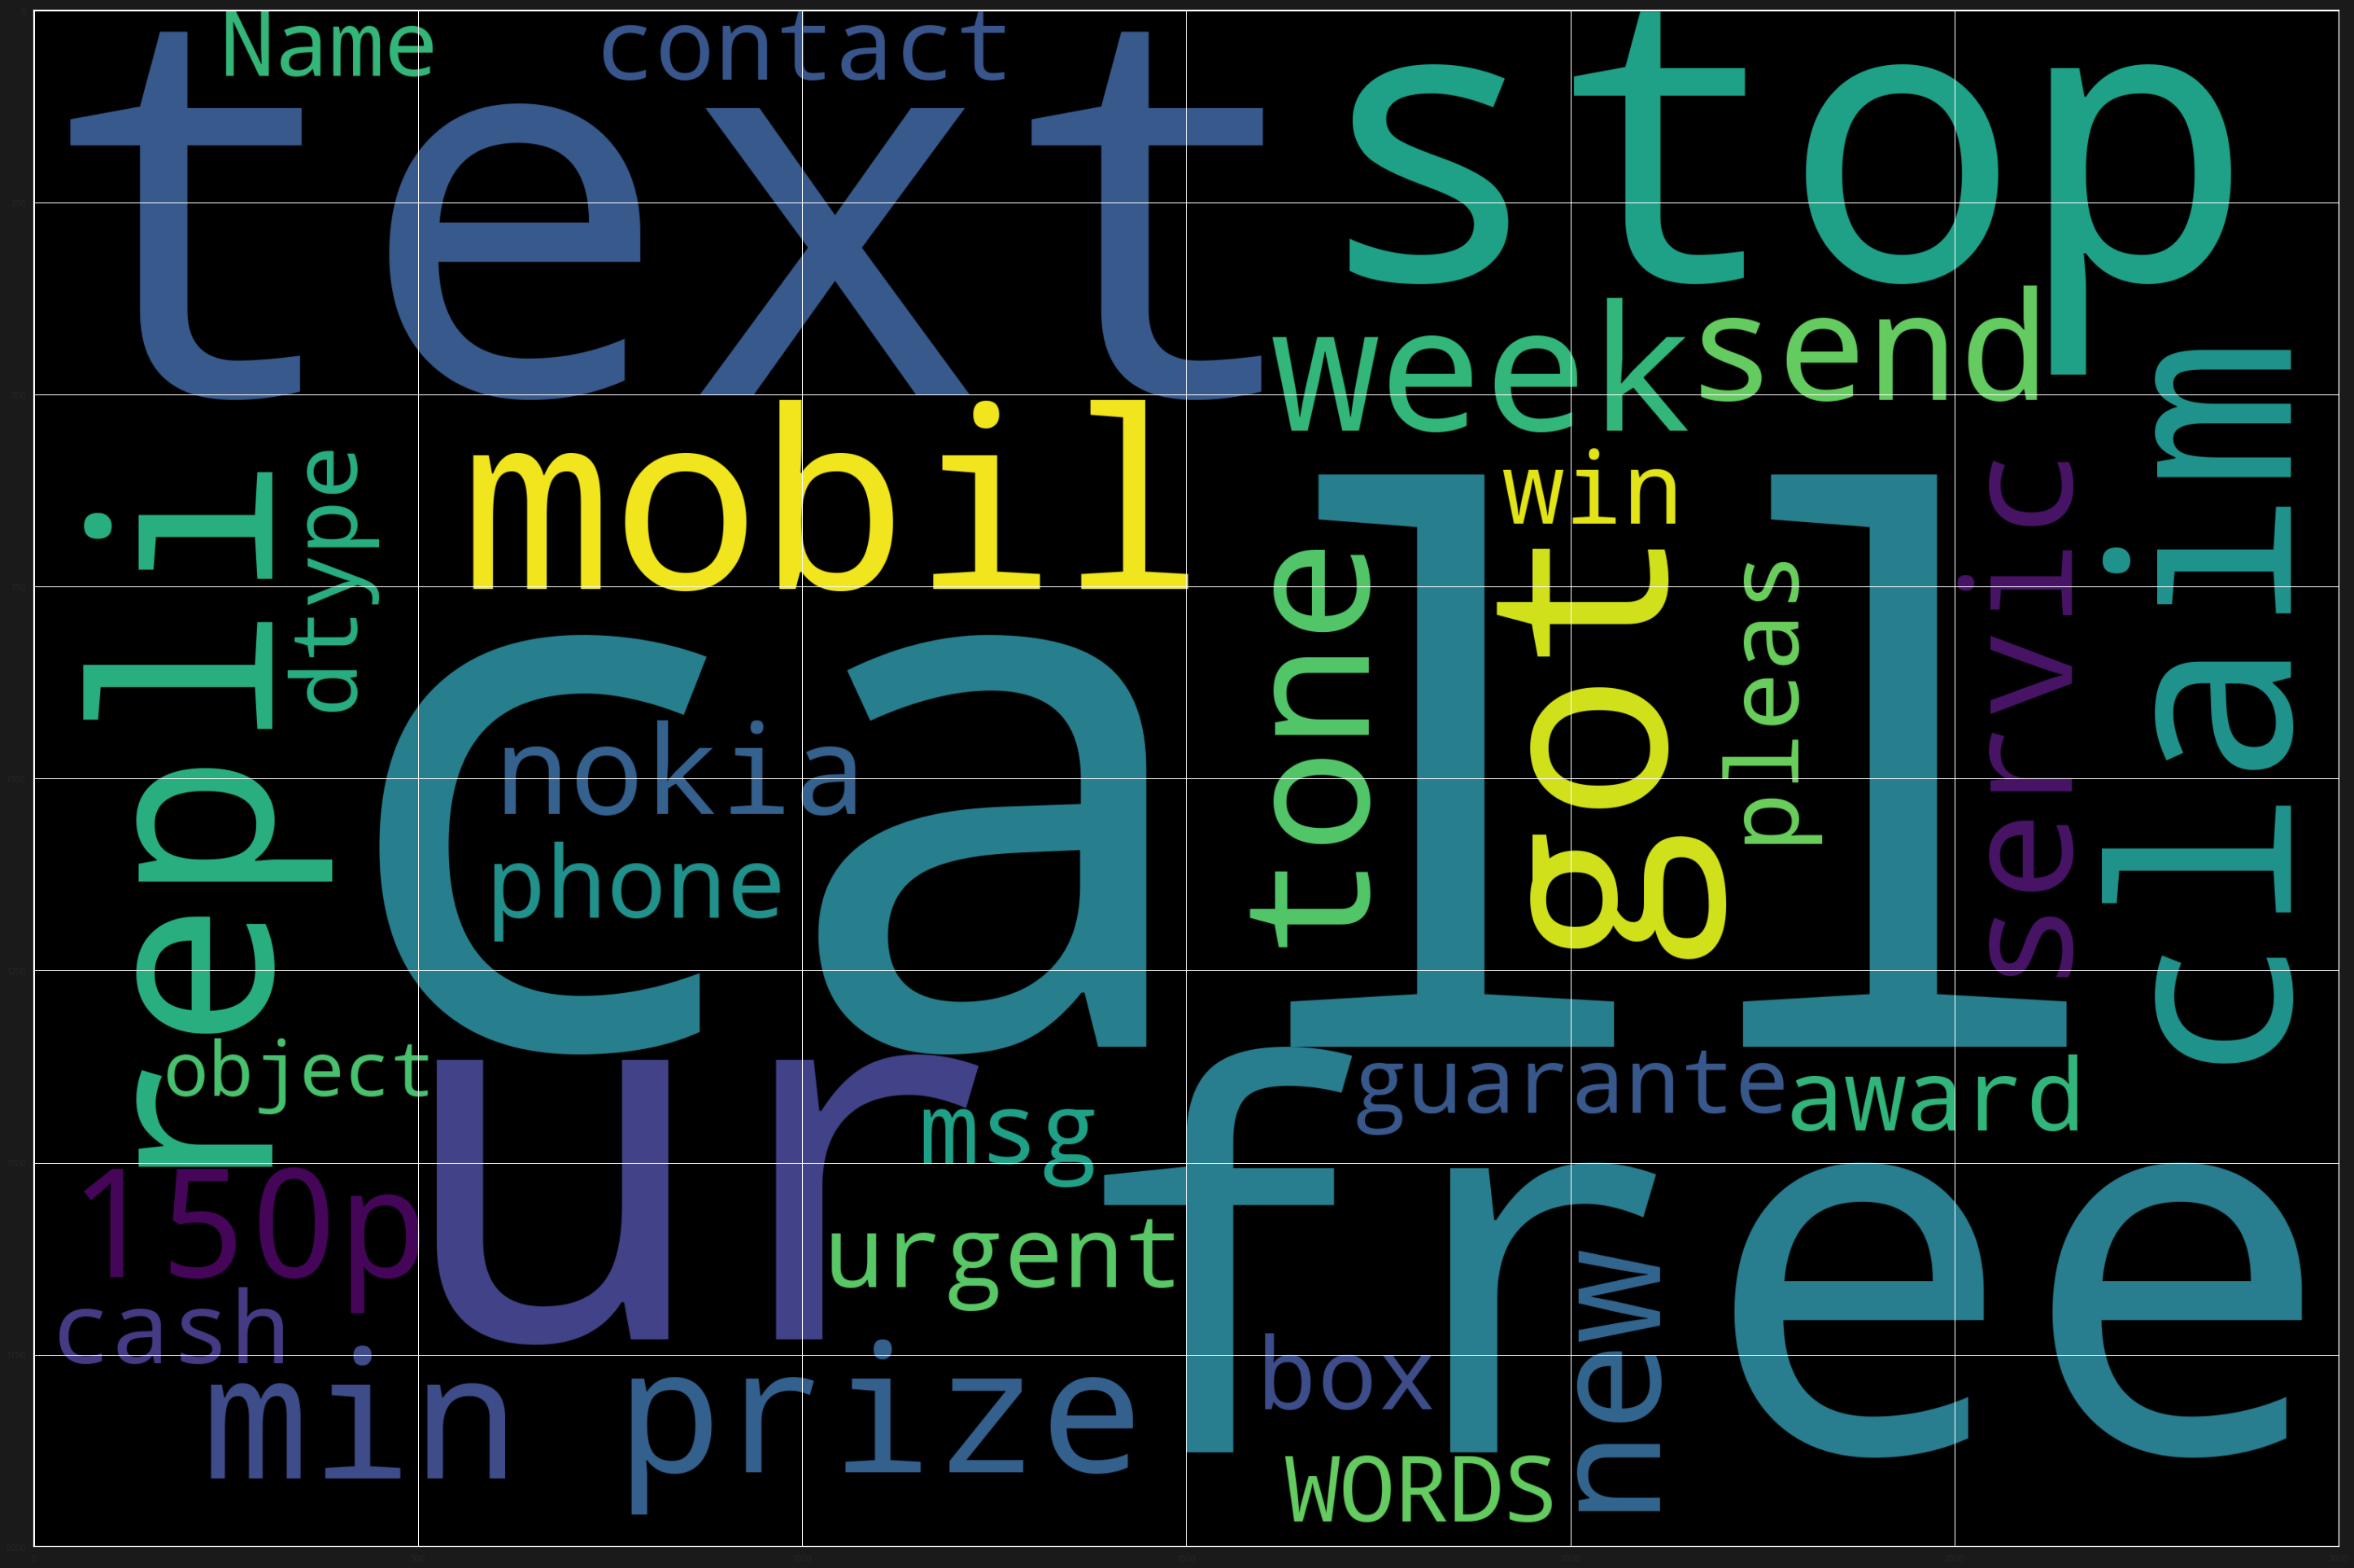

In [38]:
# wordcloud of frequent values
# ref to https://www.datacamp.com/community/tutorials/wordcloud-python and
# https://www.mikulskibartosz.name/word-cloud-from-a-pandas-data-frame/
spam_freq = spamfreq.WORDS

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black').generate(str(spam_freq))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('on')
plt.tight_layout(pad=0)
plt.show()


> **Good**

In [39]:
goodcount_list=freq_table(good_unique_list,goodlist) # get count of unique word occurence
goodfreq = pd.DataFrame({'WORDS' : good_unique_list, 'FREQUENCY' : goodcount_list}) # put into dataframe
goodfreq=goodfreq.sort_values(by=['FREQUENCY'],ascending=False) # sort by descending
goodfreq= goodfreq.head(n=30) # only get top 30 values

goodfreq.head()

WORDS  FREQUENCY
87      u        897
121   got        635
144    go        404
83   come        275
10     ok        247

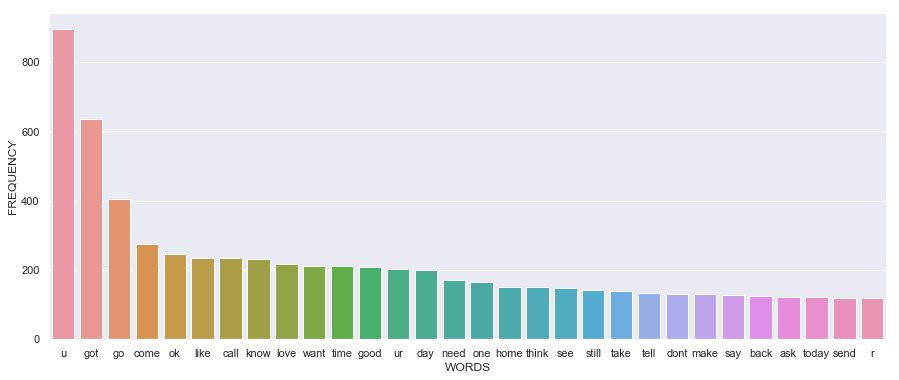

In [40]:
fig = plt.figure(figsize=(15,6))
sb.barplot(x="WORDS", y="FREQUENCY",data=goodfreq)

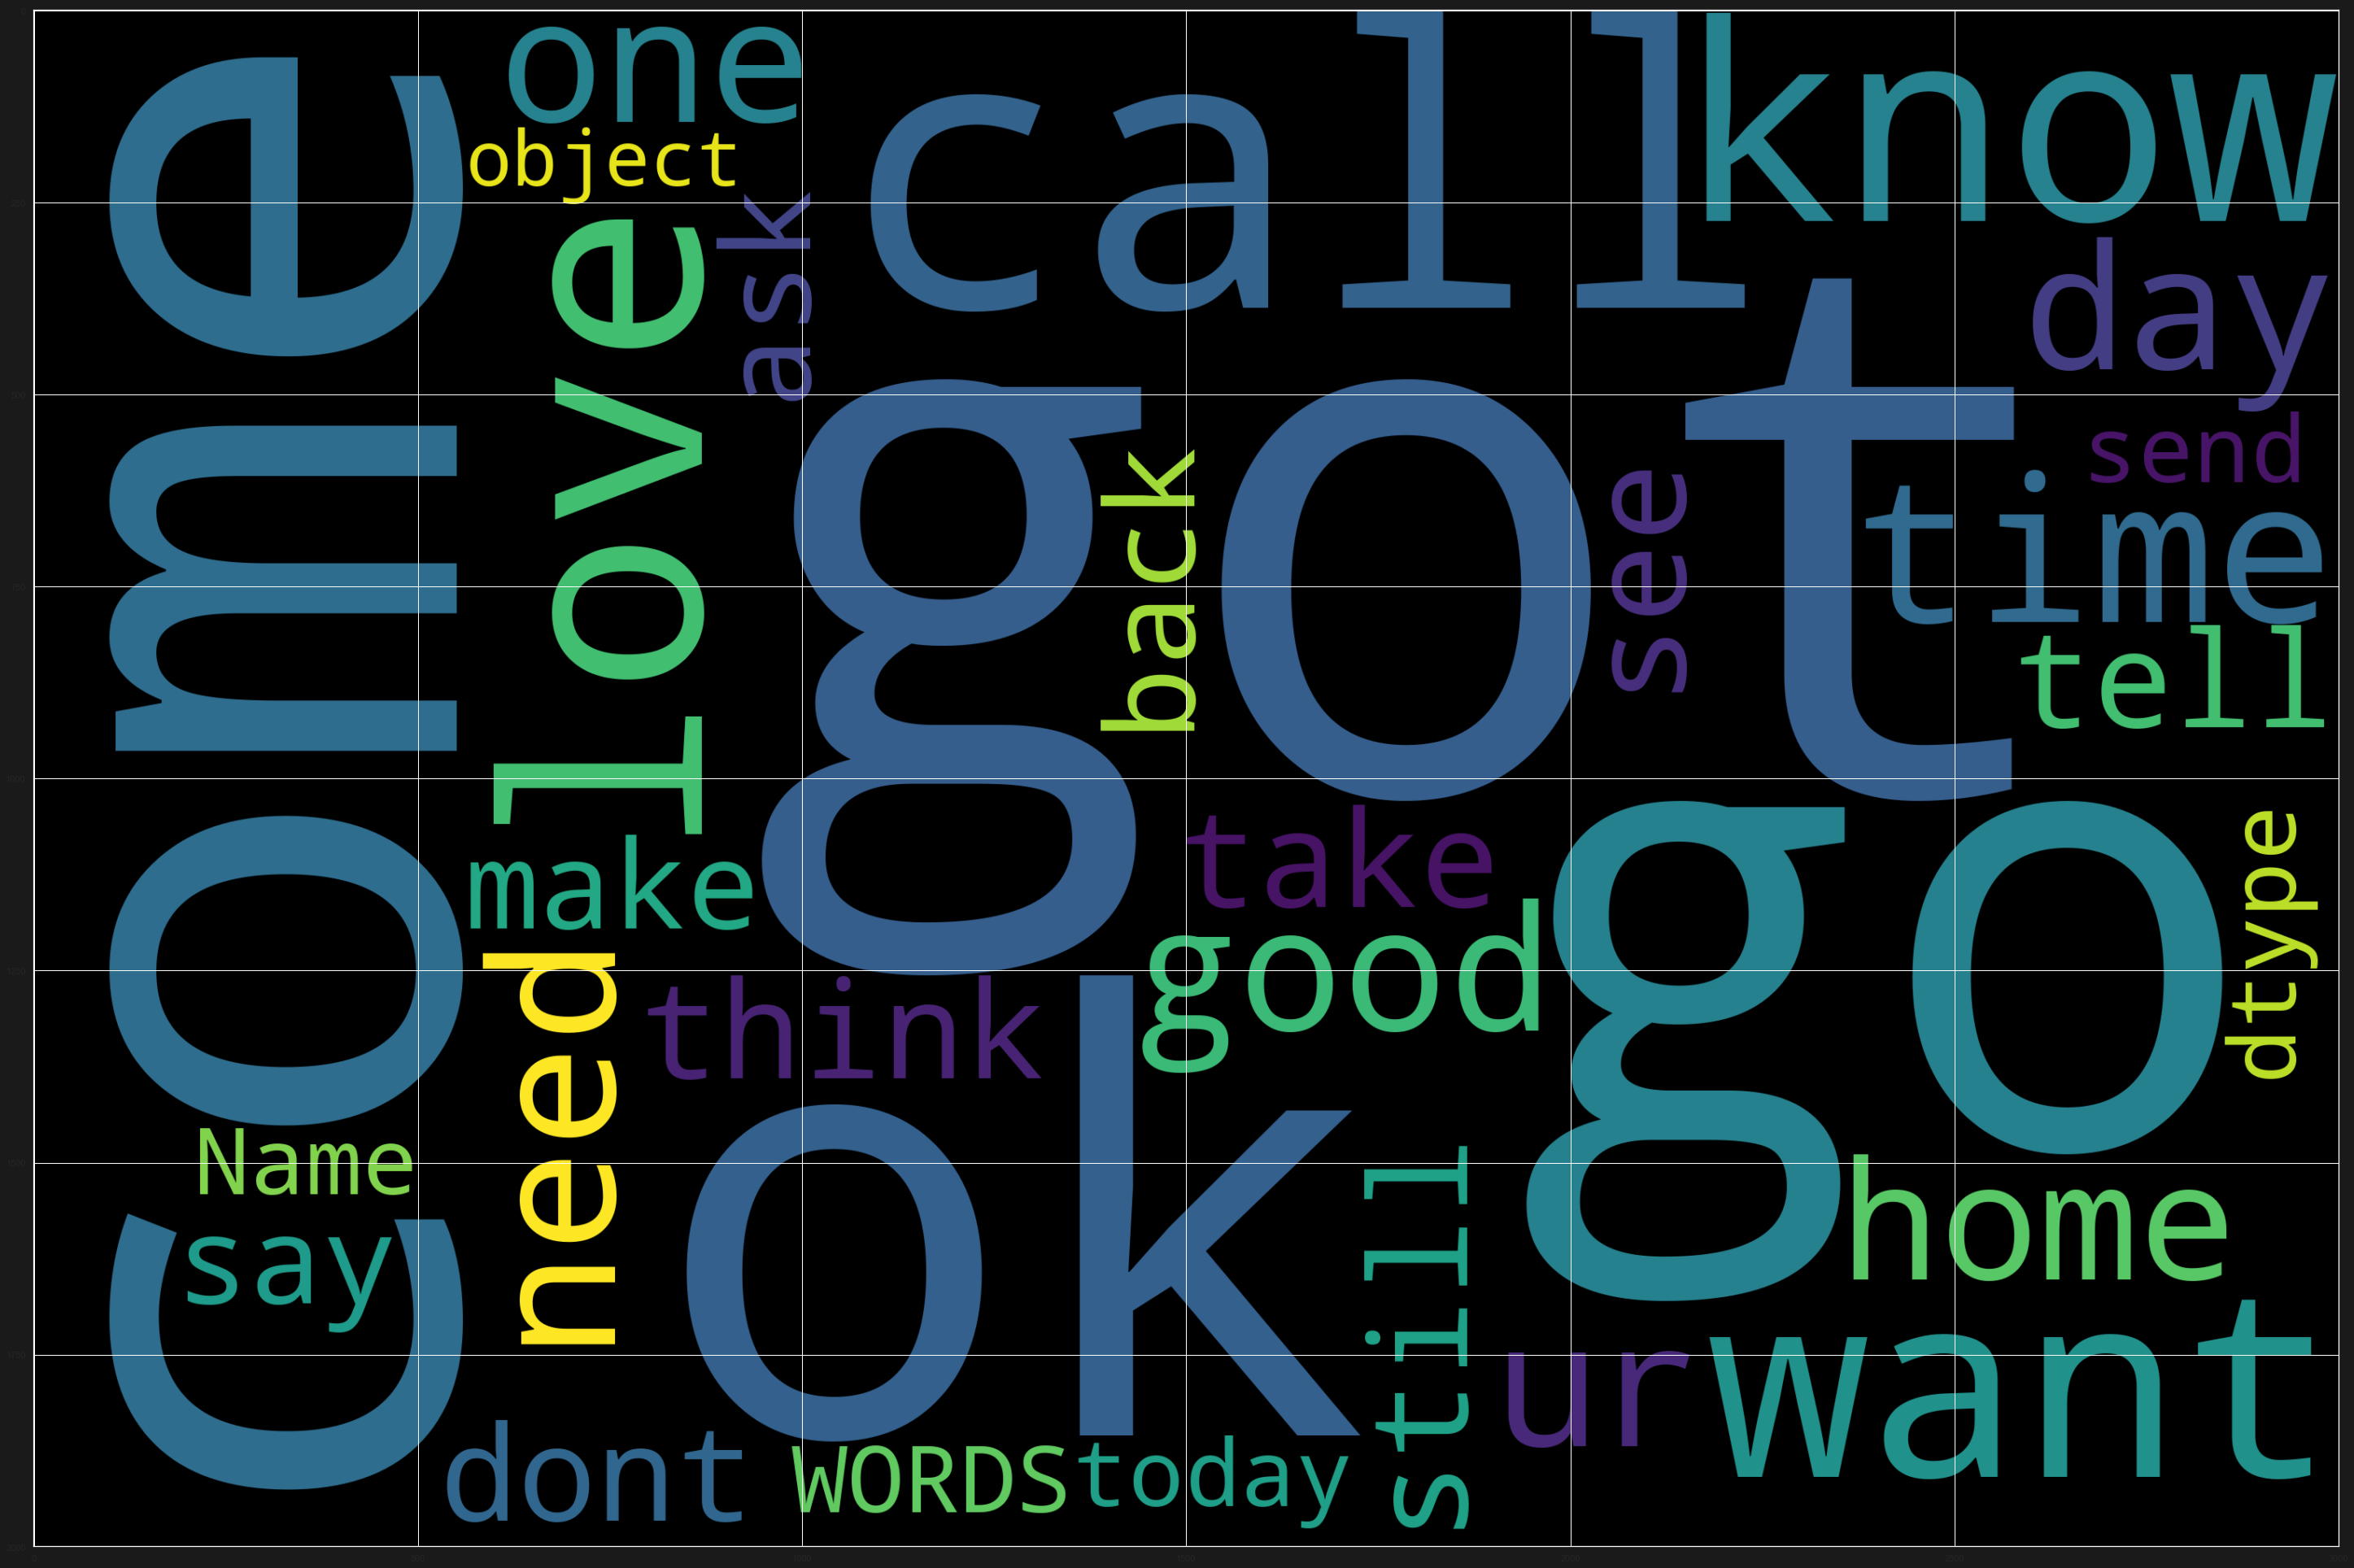

In [41]:
good_freq = goodfreq.WORDS

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black').generate(str(good_freq))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('on')
plt.tight_layout(pad=0)
plt.show()


In [42]:
smsData['TEXTSTRING'] = smsData.TEXT.apply(' '.join)

**Increasing predictors** <br>
Occurence of common words in dataframe<br>
common good words eg 'u | got | come | ok | call'<br>
common spam words eg 'call | text | free | u | ur'

In [43]:
good_freq_count= smsData['TEXTSTRING'].str.count(" u | got | come | ok | call | like | know | love | time | want | good | ur | day | need | one | home | think | see | still | take | tell | dont | make | say | back | today | ask | send | r ")
spam_freq_count= smsData['TEXTSTRING'].str.count(" call | text | free | u | ur | stop | mobil | repli | daim | got | prize | week | min | 150p | tone | servic | new | send | nokia | urgent | award | contact | phone | cash | box | pleas | msg | win | c | guarante ")

In [44]:
good_freq_count=good_freq_count.to_frame(name="GOOD WORDS")
smsData_ref['GOOD WORDS'] = good_freq_count["GOOD WORDS"]

spam_freq_count=spam_freq_count.to_frame(name="SPAM WORDS")
smsData_ref['SPAM WORDS']=spam_freq_count["SPAM WORDS"]

smsData_ref['TEXTS']=smsData_nodup['TEXT']

**Check:**

In [45]:
smsData_ref

LABEL  LENGTH  PUNCT COUNT URLs HTMLs  DIGIT COUNT DATETIME  GOOD WORDS  \
0         0      16            9    0     0            0        0           1   
1         0       6            6    0     0            0        0           1   
2         0       9            6    0     0            0        0           2   
3         0       7            2    0     0            0        0           1   
4         1      20            9    0     0            4        1           5   
...     ...     ...          ...  ...   ...          ...      ...         ...   
5153      1      22            9    0     0           21        1           3   
5154      0       6            2    0     0            0        0           0   
5155      0       5            7    0     0            0        0           0   
5156      0      14            1    0     0            0        0           1   
5157      0       3            1    0     0            0        0           0   

      SPAM WORDS                                              TEXTS  
0              1  Go until jurong point, crazy.. Available only ...  
1              1                      Ok lar... Joking wif u oni...  
2              1  U dun say so early hor... U c already then say...  
3              0  Nah I don't think he goes to usf, he lives aro...  
4              2  FreeMsg Hey there darling it's been 3 week's n...  
...          ...                                                ...  
5153           4  This is the 2nd time we have tried 2 contact u...  
5154           0               Will ü b going to esplanade fr home?  
5155           0  Pity, * was in mood for that. So...any other s...  
5156           1  The guy did some bitching but I acted like i'd...  
5157           0                         Rofl. Its true to its name  

[5158 rows x 10 columns]

---
## Multi-Variate Classification Tree  

Response Variable : **Label**     
Predictor Feature : **Length, Punctuation count, Urls, Htmls, Good words, Spam words, Digit count, Datetime**       


In [46]:
Predictors= ['LENGTH', 'PUNCT COUNT', 'URLs', 'HTMLs', 'GOOD WORDS', 'SPAM WORDS', "DIGIT COUNT", 'DATETIME']

In [47]:
y = pd.DataFrame(smsData_ref['LABEL'])  # Response
X = pd.DataFrame(smsData_ref[Predictors])# Predictor

Train-test split into 70-30%

In [48]:
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

Train Set : (3868, 1) (3868, 8)
Test Set  : (1290, 1) (1290, 8)


#### Basic Exploration

Perform basic statistical exploration and visualization on the Train Set.

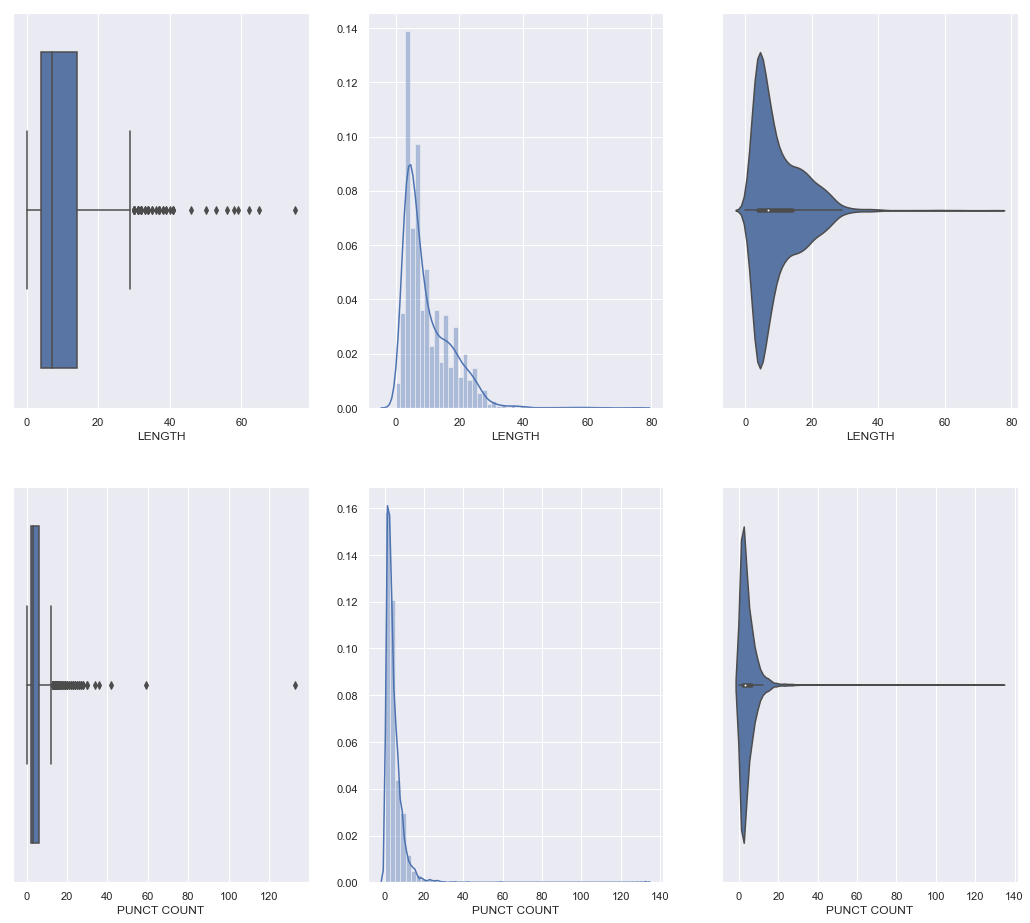

In [49]:
f, axes = plt.subplots(2, 3, figsize=(18, 16))


sb.boxplot(X_train['LENGTH'], orient = "h", ax = axes[0,0])
sb.distplot(X_train['LENGTH'], ax = axes[0,1])
sb.violinplot(X_train['LENGTH'], ax = axes[0,2])

sb.boxplot(X_train['PUNCT COUNT'], orient = "h", ax = axes[1,0])
sb.distplot(X_train['PUNCT COUNT'], ax = axes[1,1])
sb.violinplot(X_train['PUNCT COUNT'], ax = axes[1,2])


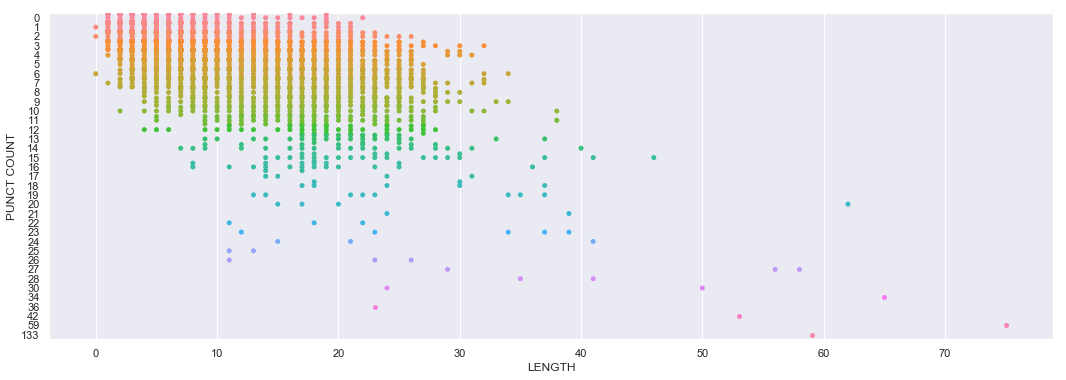

In [50]:
# Create a joint dataframe by concatenating length and punctuation count
jointDF = pd.concat([X_train['LENGTH'], X_train['PUNCT COUNT'].reindex(index=X_train['LENGTH'].index)], sort = False, axis = 1)

# Joint Swarmplot of length Train against punctuation count Train
f, axes = plt.subplots(1, 1, figsize=(18, 6))
sb.swarmplot(x = "LENGTH", y = "PUNCT COUNT", data = jointDF, orient = "h")

#### Decision Tree in Scikit-Learn

Train the Decision Tree Classifier model `dectree` using the Train Set.   
Use `X_train` as *Predictor* and `y_train` as *Response*.

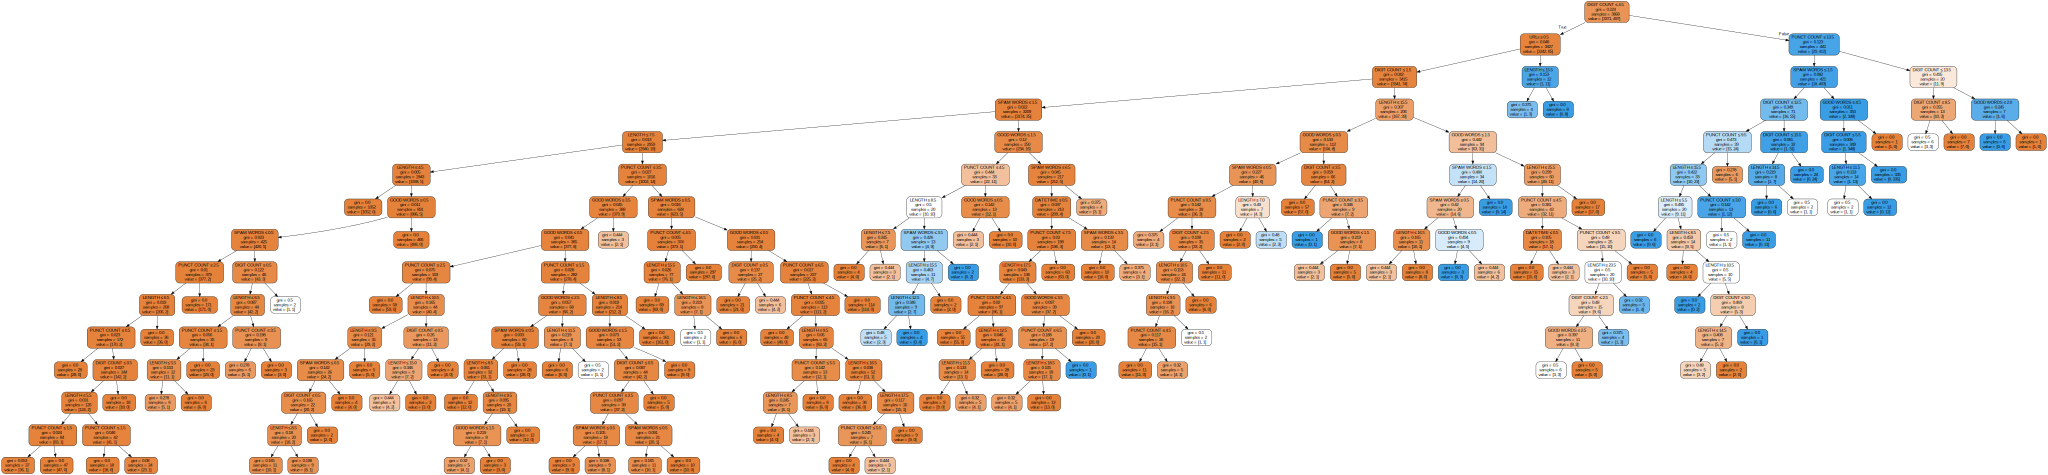

In [51]:
# Import DecisionTreeClassifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(min_samples_split=7)  # create the decision tree object
fitted=dectree.fit(X_train, y_train)                    # train the decision tree model

# Plot the Decision Tree
from sklearn.tree import export_graphviz
treedot = export_graphviz(dectree,                                      # the model
                          feature_names = X_train.columns,              # the features 
                          out_file = None,                              # output file
                          filled = True,                                # node colors
                          rounded = True,                               # make pretty
                          special_characters = True)                    # postscript

import graphviz
graphviz.Source(treedot)

#### Goodness of Fit of the Model

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9865563598759048

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.9775193798449613



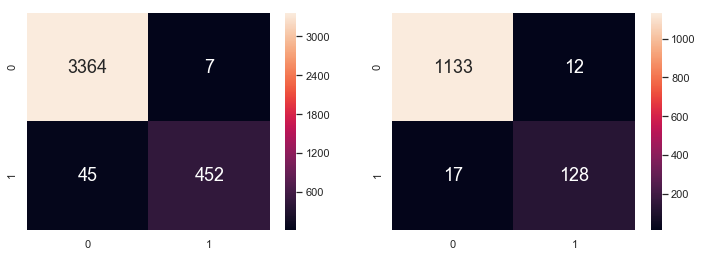

In [52]:
# Predict Legendary values corresponding to Total
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

In [53]:
smsData_ref

LABEL  LENGTH  PUNCT COUNT URLs HTMLs  DIGIT COUNT DATETIME  GOOD WORDS  \
0         0      16            9    0     0            0        0           1   
1         0       6            6    0     0            0        0           1   
2         0       9            6    0     0            0        0           2   
3         0       7            2    0     0            0        0           1   
4         1      20            9    0     0            4        1           5   
...     ...     ...          ...  ...   ...          ...      ...         ...   
5153      1      22            9    0     0           21        1           3   
5154      0       6            2    0     0            0        0           0   
5155      0       5            7    0     0            0        0           0   
5156      0      14            1    0     0            0        0           1   
5157      0       3            1    0     0            0        0           0   

      SPAM WORDS                                              TEXTS  
0              1  Go until jurong point, crazy.. Available only ...  
1              1                      Ok lar... Joking wif u oni...  
2              1  U dun say so early hor... U c already then say...  
3              0  Nah I don't think he goes to usf, he lives aro...  
4              2  FreeMsg Hey there darling it's been 3 week's n...  
...          ...                                                ...  
5153           4  This is the 2nd time we have tried 2 contact u...  
5154           0               Will ü b going to esplanade fr home?  
5155           0  Pity, * was in mood for that. So...any other s...  
5156           1  The guy did some bitching but I acted like i'd...  
5157           0                         Rofl. Its true to its name  

[5158 rows x 10 columns]

Predict Label for 5155 text (shown above)

In [54]:
# Extract texts for Prediction
pred = smsData_ref[smsData_ref["TEXTS"].isin(["I‘m going to try for 2 months ha ha only joking", "Are you unique enough? Find out from 30th August. www.areyouunique.co.uk"])]
pred

LABEL  LENGTH  PUNCT COUNT URLs HTMLs  DIGIT COUNT DATETIME  GOOD WORDS  \
15       0       8            1    0     0            1        1           0   
163      1       6            5    1     0            2        0           0   

     SPAM WORDS                                              TEXTS  
15            0    I‘m going to try for 2 months ha ha only joking  
163           0  Are you unique enough? Find out from 30th Augu...

In [55]:
# Extract Predictors for Prediction
X_pred = pd.DataFrame(pred[Predictors])

# Predict Response corresponding to Predictors
y_pred = dectree.predict(X_pred)
y_pred

array([0, 1])

In [56]:
# Summarize the Actuals and Predictions
y_pred = pd.DataFrame(y_pred, columns = ["PredLabel"], index = pred.index)
smsdata_acc = pd.concat([pred[["TEXTS", "LABEL"]], y_pred], axis = 1)

smsdata_acc

TEXTS  LABEL  PredLabel
15     I‘m going to try for 2 months ha ha only joking      0          0
163  Are you unique enough? Find out from 30th Augu...      1          1

#### Prediction of Class Probabilities

In [57]:
# Predict Probabilities corresponding to Predictors
y_prob = dectree.predict_proba(X_pred)
# Summarize the Probabilities with the Predictions
y_prob = pd.DataFrame(list(y_prob[:,1]), columns = ["ProbLabel"], index = pred.index)
smsdata_conf = pd.concat([smsdata_acc, y_prob], axis = 1)

smsdata_conf

TEXTS  LABEL  PredLabel  \
15     I‘m going to try for 2 months ha ha only joking      0          0   
163  Are you unique enough? Find out from 30th Augu...      1          1   

     ProbLabel  
15        0.00  
163       0.75

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9772492244053774

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.9899224806201551



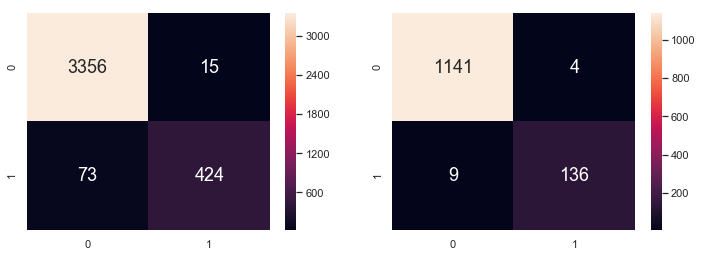

In [58]:
# Random Forest using Train Data
rforest = RandomForestClassifier(n_estimators = 100, max_depth = 4)  # create the object
rforest.fit(X_train, y_train.values.ravel())                         # train the model

# Predict Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)
y_test_pred = rforest.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", rforest.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", rforest.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

Prediction of same texts:

In [59]:
# Extract texts for Prediction
pred = smsData_ref[smsData_ref["TEXTS"].isin(["I‘m going to try for 2 months ha ha only joking", "Are you unique enough? Find out from 30th August. www.areyouunique.co.uk"])]
pred

LABEL  LENGTH  PUNCT COUNT URLs HTMLs  DIGIT COUNT DATETIME  GOOD WORDS  \
15       0       8            1    0     0            1        1           0   
163      1       6            5    1     0            2        0           0   

     SPAM WORDS                                              TEXTS  
15            0    I‘m going to try for 2 months ha ha only joking  
163           0  Are you unique enough? Find out from 30th Augu...

In [60]:
# Extract Predictors for Prediction
X_pred = pd.DataFrame(pred[Predictors])

# Predict Response corresponding to Predictors
y_pred = rforest.predict(X_pred)
y_pred

array([0, 1])

In [61]:
# Summarize the Actuals and Predictions
y_pred = pd.DataFrame(y_pred, columns = ["PredLabel"], index = pred.index)
smsdata_acc = pd.concat([pred[["TEXTS", "LABEL"]], y_pred], axis = 1)

smsdata_acc

TEXTS  LABEL  PredLabel
15     I‘m going to try for 2 months ha ha only joking      0          0
163  Are you unique enough? Find out from 30th Augu...      1          1

#### Prediction of Class Probabilities

In [62]:
# Predict Probabilities corresponding to Predictors
y_prob = rforest.predict_proba(X_pred)
# Summarize the Probabilities with the Predictions
y_prob = pd.DataFrame(list(y_prob[:,1]), columns = ["ProbLabel"], index = pred.index)
smsdata_conf = pd.concat([smsdata_acc, y_prob], axis = 1)

smsdata_conf

TEXTS  LABEL  PredLabel  \
15     I‘m going to try for 2 months ha ha only joking      0          0   
163  Are you unique enough? Find out from 30th Augu...      1          1   

     ProbLabel  
15    0.034338  
163   0.507563

# Probability of spam: Naive Bayes Algorithm
---
### P(Spam | Dataset) = P(Dataset | Spam) * P(Spam) / P (Dataset)
---

In [63]:
## count vector, naive bayes reference to
## https://www.kaggle.com/snehithatiger/spam-or-ham-classification/notebook

In [64]:
mnb = MultinomialNB(alpha = 0.5)
mnb.fit(X_train,y_train.values.ravel())

y_mnb = mnb.predict(X_test)

Naive Bayes Accuracy:  0.9782945736434109


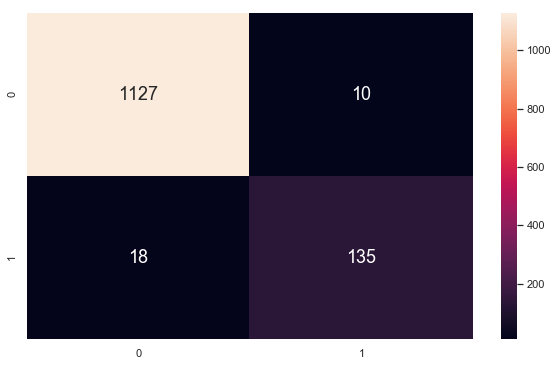

In [65]:
print('Naive Bayes Accuracy: ', accuracy_score( y_mnb , y_test))
fig = plt.figure(figsize=(10,6))
sb.heatmap(confusion_matrix(y_mnb, y_test),
           annot = True, fmt=".0f", annot_kws={"size": 18})


*Conclusion*<br>
Binary tree classifier is a better classification compared to Random forest and Naive Bayes.<br>
Even though Binary tree performed better in this case, random forest seems more prone to overfit the data<br>
Compared to Binary tree. This could have been due to overfitting resulted in random forest<br>
As seen above, the probability of correct label in Random forest also has a lower probability <br>
This might be because of the abundance of trees hence difficult to get a 100% probability on each prediction<br>
However, if the dataset were to be larger and more ambigious<br> eg classification of spooky authors <https://www.kaggle.com/c/spooky-author-identification> <br>
It might be more consistent in terms of classification with a higher prediction probability than binary tree<br>
Naive Bayes is also not as accurate as it does not work well with a lot of data compared to decision trees<br>

*Improvements:*<br>
Include counts of whereby texts contains numbers and alphabets together eg. 342ghs, 887hs65v, iud7c<br>
Increase accuracy of matching to date and time using regex<br>
Included more tools to predict accuracy eg. TF-IDF, SVM, XGBoost

# References
---
Basic analysis - M2 ExploratoryAnalysis.ipynb <br>
Classification tree and random forest - M4 ClassificationTree.ipynb and M4 RandomForest.ipynb<br>
identifying string length - https://www.edureka.co/community/46313/python-pandas-find-length-of-string-in-dataframe<br>
dropping duplicates - https://www.geeksforgeeks.org/python-pandas-dataframe-drop_duplicates/<br>
regex substitution - https://docs.python.org/3/library/re.html<br>
tokenization - https://stackoverflow.com/questions/34714162/preventing-splitting-at-apostrophies-when-tokenizing-words-using-nltk<br>
stopwords - https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe<br>
Label Encoder - https://www.datacamp.com/community/tutorials/categorical-data<br>
word stem - https://stackoverflow.com/questions/37443138/python-stemming-with-pandas-dataframe<br>
word cloud - https://www.datacamp.com/community/tutorials/wordcloud-python and https://www.mikulskibartosz.name/word-cloud-from-a-pandas-data-frame/<br>
Naive bayes - https://www.kaggle.com/snehithatiger/spam-or-ham-classification/notebook
